In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn

In [2]:
mnist = MNIST(root = './', 
                train = True,
                transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
                )

In [3]:
img, label = mnist[5]
# print(img)
print(label)

2


In [4]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0 , 1)

Label: 2


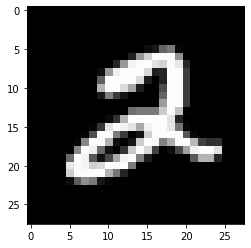

In [5]:
%matplotlib inline
denorm(img)
plt.imshow(img[0], cmap = 'gray')
print('Label:', label)

In [6]:
data_batch = DataLoader(dataset = mnist,
                            batch_size = 100,
                            shuffle = True)

torch.Size([100, 1, 28, 28])
tensor([4, 1, 3, 3, 4, 0, 7, 9, 7, 1, 9, 7, 6, 6, 2, 9, 9, 4, 1, 5, 2, 2, 1, 5,
        6, 8, 5, 3, 0, 7, 9, 2, 5, 8, 4, 9, 0, 9, 2, 1, 9, 7, 6, 0, 4, 7, 1, 3,
        1, 7, 6, 1, 4, 9, 2, 0, 0, 9, 7, 7, 5, 7, 0, 9, 1, 8, 4, 6, 6, 2, 1, 1,
        0, 8, 6, 8, 8, 8, 1, 3, 9, 3, 4, 2, 9, 2, 6, 4, 5, 6, 9, 9, 1, 6, 2, 4,
        8, 0, 2, 9])


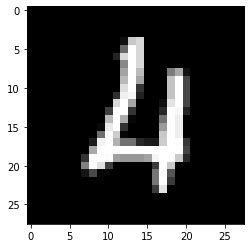

In [7]:
for img, label in data_batch:
    print(img.shape)
    # print(img[0][0])
    plt.imshow(img[0][0], cmap = 'gray')
    print(label)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [10]:
image_size = 784
hidden_state = 256

In [11]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_state),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_state, hidden_state),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_state, 1),
    nn.Sigmoid()
)

In [12]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [13]:
latent_size = 128

In [14]:
G = nn.Sequential(
        nn.Linear(latent_size, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, image_size),
        nn.Tanh()
)

In [15]:
G.to(device)

Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

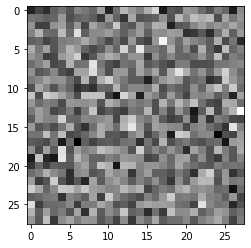

In [16]:
y = G(torch.randn(3, latent_size))
generated_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(generated_imgs[0], cmap = 'gray')

In [17]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [18]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    outputs = D(images)
    d_loss_real = loss_fn(outputs, real_labels)
    real_score = outputs

    gen_fake_img_for_d = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(gen_fake_img_for_d)
    outputs = D(fake_images)
    d_loss_fake = loss_fn(fake_images, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake

    d_loss.backward()

    d_optimizer.step()

    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    return d_loss, real_score, fake_score




In [20]:
def train_generator():
    z = torch.randn(batch_size, latent_size).detach()
    fake_image = G(z)
    labels = torch.ones(batch_size, 1).detach()
    g_loss = loss_fn(D(fake_image), labels)

    g_loss.backward()
    g_optimizer.step()
    d_optimizer.reset_grad()
    g_optimizer.reset_grad()

    return g_loss, fake_image
